In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

config_folder = Path("../configs/Chicago")

# get populationsim synthetic population
popsim_df = pd.read_csv(config_folder / "data/populationsim/output/synthetic_persons.csv")

# get PUMS dataset from POLARIS
pums_df = pd.read_csv(config_folder / "data/populationsim/data/pums_person_chicago.csv", dtype=str)

# get PUMS PUMA geography
# https://catalog.data.gov/dataset/tiger-line-shapefile-2019-2010-state-illinois-2010-census-public-use-microdata-area-puma-state-
puma_gdf = gpd.read_file(config_folder / "data/tl_2019_17_puma10.shp")

# get CMAP planning area
# https://datahub.cmap.illinois.gov/datasets/4834d52310d24e56a0300898a0cb23bc_0/explore
cmap_gdf = gpd.read_file(config_folder / "data/Facility_Planning_Areas_2016.shp")

In [ ]:
pums_df

In [ ]:
pums_df.dtypes

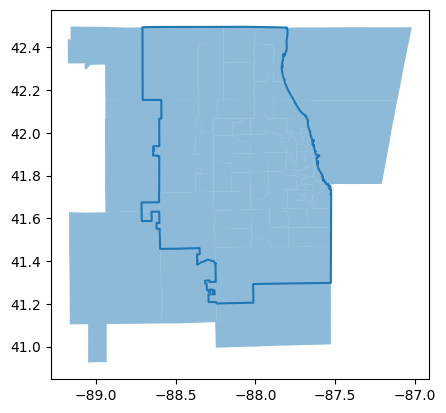

In [2]:
# get puma areas within cmap planning boundary
cmap_gdf.to_crs(puma_gdf.crs, inplace=True)

cmap_boundary = cmap_gdf.geometry.union_all()

puma_in_cmap_gdf = puma_gdf[puma_gdf.geometry.intersects(cmap_boundary)].reset_index(drop=True)



fig, ax = plt.subplots()

puma_in_cmap_gdf.plot(ax=ax, alpha=0.5)
x, y = cmap_boundary.exterior.xy
ax.plot(x, y)

plt.show()

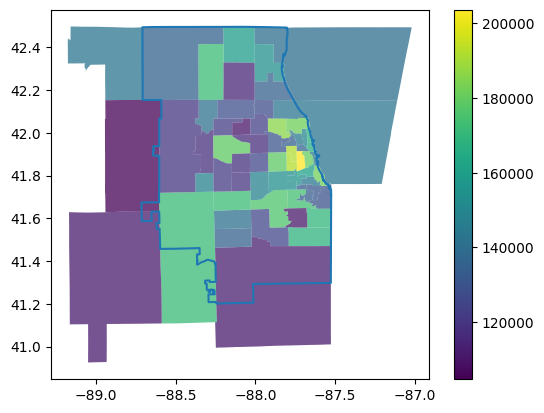

In [3]:
# add STPUMA to puma_in_cmap gdf
puma_in_cmap_gdf["STPUMA"] = puma_in_cmap_gdf["PUMACE10"].apply(
    lambda x: int("17" + str(x))
)

# get population totals by STPUMA from popsim df
pop_totals = popsim_df.groupby("STPUMA").size().reset_index(name="count")
pop_totals.columns = ["STPUMA", "POP_COUNT"]
puma_with_pop_gdf = puma_in_cmap_gdf.merge(pop_totals, how="left", left_on="STPUMA", right_on="STPUMA")

# get share of population in PUMA areas
puma_with_pop_gdf["SHARE"] = puma_with_pop_gdf.POP_COUNT / puma_with_pop_gdf.POP_COUNT.sum()

fig, ax = plt.subplots()

puma_with_pop_gdf.plot(ax=ax, alpha=0.75, column="POP_COUNT", legend=True)
x, y = cmap_boundary.exterior.xy
ax.plot(x, y)

plt.show()

In [4]:
# okay now filter PUMS dataset by SERIALNO in popsim
pums_in_popsim_df = pums_df[pums_df.SERIALNO.isin(popsim_df.SERIALNO.astype(str).unique())]
pums_in_popsim_df

,SERIALNO,SPORDER,PUMA,ST,ADJINC,PWGTP,AGEP,COW,JWMNP,JWRIP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,1,1,3501,17,1010145,8,19,0.0,0.0,0.0,...,17,16,15,1,8,9,16,1,9,2
2,3,1,3309,17,1010145,35,22,5.0,0.0,0.0,...,71,1,1,37,30,40,35,78,1,75
3,4,1,3526,17,1010145,4,64,0.0,0.0,0.0,...,3,3,0,3,7,1,0,6,3,6
4,5,1,3421,17,1010145,1,53,1.0,0.0,0.0,...,1,1,1,1,1,0,1,1,1,1
6,7,1,3203,17,1010145,22,19,0.0,0.0,0.0,...,3,4,38,41,4,22,39,3,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123564,55107,5,3106,17,1010145,18,14,0.0,0.0,0.0,...,19,19,6,20,4,18,20,20,32,36
123565,55108,1,3504,17,1010145,13,83,0.0,0.0,0.0,...,4,4,23,14,13,23,13,23,15,4
123566,55108,2,3504,17,1010145,18,82,0.0,0.0,0.0,...,5,4,31,17,17,30,16,29,18,6
123567,55109,1,3005,17,1010145,10,68,1.0,15.0,1.0,...,10,3,15,19,4,10,12,3,9,2


In [5]:

n_sample = 2000

samples = []
for _, row in puma_with_pop_gdf.iterrows():
    STPUMA = str(row.STPUMA)
    share = row.SHARE

    n = max(int(share*n_sample), 1)
    sample = pums_in_popsim_df[pums_in_popsim_df.STPUMA==STPUMA].sample(
        n=n,
        replace=False,
        random_state=0)
    samples.append(sample)

pums_sample = pd.concat(samples).reset_index(drop=True)




In [ ]:
pums_sample